# Práctico N°1 Análisis de Grafos

Integrantes: Nicolás Benjamín Ocampo, Antonela Sambuceti

En este práctico, trabajaremos con un dataset extraído de Twitter. La idea es emplear los conceptos de grafos vistos en clase sobre un caso real de actualidad.

## Dataset

El dataset consiste en un conjunto de hilos de tweets, con un total de ~150000 tweets, extraídos entre Enero y Marzo de 2021. La temática de los mismos está referida a la vacunación contra el covid-19 en Argentina.

Pueden descargar el dataset del siguiente [link](https://drive.google.com/file/d/1X_qKsE8muAnom2tDX4sLlmBAO0Ikfe_G/view?usp=sharing).

### Campos

- **created_at:** Fecha del tweet
- **id_str:** ID del tweet
- **full_text:** Contenido del tweet
- **in_reply_to_status_id:** ID del tweet inmediatamente anterior en el hilo
- **in_reply_to_user_id:** Autor del tweet inmediatamente anterior en el hilo
- **user.id:** Autor del tweet
- **user_retweeters:** Lista de ID de usuarios que retweetearon el tweet
- **sentiment:** Etiquetado manual que indica el sentimiento o intención del tweet con respecto al tweet anterior en el hilo

## Configuración inicial

In [1]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import math
from cdlib import NodeClustering, evaluation, algorithms
import igraph as ig
import networkx as nx

from nltk import (corpus, tokenize, download)
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
download("stopwords")
download('punkt')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\anto_\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\anto_\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### Cargamos el dataset

In [2]:
DATASET_FILE = "dataset/vacunas.csv"

dtypes = {
    'id_str': str,
    'full_text': str,
    'in_reply_to_status_id': str,
    'in_reply_to_user_id': str,
    'user.id': str
}
df = pd.read_csv(DATASET_FILE, dtype=dtypes).dropna(subset=['user_retweeters'])
df['user_retweeters'] = df['user_retweeters'].apply(lambda x: [str(elem) for elem in eval(x)])
print(df.shape)
df.head()

(155123, 8)


,created_at,id_str,full_text,in_reply_to_status_id,in_reply_to_user_id,user.id,user_retweeters,sentiment
0,Sat Feb 20 03:09:10 +0000 2021,1362962469749153792,Seguimos esperando el comunicado de @norabar r...,NaN,NaN,2737379453,"[2258074658, 159909978, 105301854, 290671142, ...",NaN
1,Sat Feb 20 03:19:59 +0000 2021,1362965193509265417,@Clon_43 @norabar Nora estaba indignada porque...,1362962469749153792,2737379453,32718111,[],NaN
2,Mon Feb 22 23:55:08 +0000 2021,1364000806740111363,"Bueno, Alberto dijo Salud o Economía. La salud...",NaN,NaN,252168075,"[1238117630696972289, 37232479, 12792246571247...",NaN
3,Tue Feb 23 00:09:14 +0000 2021,1364004354374696963,@spitta1969 Tuit del mes Spitta,1364000806740111363,252168075,1156346340802224128,[],NaN
4,Tue Feb 23 00:00:17 +0000 2021,1364002100364128260,@spitta1969 Estas onfire,1364000806740111363,252168075,153663816,[],NaN


### Observamos algunos ejemplos

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 155123 entries, 0 to 163178
Data columns (total 8 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   created_at             155123 non-null  object
 1   id_str                 155123 non-null  object
 2   full_text              155123 non-null  object
 3   in_reply_to_status_id  151834 non-null  object
 4   in_reply_to_user_id    151949 non-null  object
 5   user.id                155123 non-null  object
 6   user_retweeters        155123 non-null  object
 7   sentiment              1029 non-null    object
dtypes: object(8)
memory usage: 10.7+ MB


In [4]:
len(df)

155123

In [5]:
idx = 0
print('Texto:', df.full_text.values[idx])
print('Retweets:', len(df.user_retweeters.values[idx]))

Texto: Seguimos esperando el comunicado de @norabar repudiando la situación respecto del gobierno y el tema vacunas. Seamos pacientes que con esto de la pandemia anda con mucho "laburo".
Retweets: 9


In [6]:
idx = 376
print('Text:', df.full_text.values[idx])
print('Retweets:', len(df.user_retweeters.values[idx]))

Text: Todo lo que hay que entender sobre la decisión –o no– de poner más vacunas en más brazos (por ejemplo, usar las 1º dosis en muchos y si es necesario retrasar la 2º) está en esta excelente nota de Nora Bär. https://t.co/A0I03DyxgO
Retweets: 48


### Calculamos la cantidad de hilos

In [7]:
roots = df[df['in_reply_to_user_id'].isna()]
roots.shape

(3174, 8)

## Actividades

### 1. Construcción del grafo

Construir el **grafo de retweets**, definido de la siguiente manera:

- Tipo de grafo: Dirigido
- Nodos: ID de los usuarios
- Enlaces: (Usuario A) ---> (Usuario B) si B retweeteó algún tweet de A

Con estos datos, el grafo debería tener alrededor de 40000 nodos y 90000 enlaces.

Considerar la versión no dirigida del grafo y estudiar su conectividad. Si existe una única "componente gigante", realizar el resto de las actividades sobre ella, en lugar de sobre el grafo completo.

Calcular las siguientes métricas globales del grafo:

- Grado medio
- Asortatividad
- Transitividad
- Coeficiente de clustering de Watts-Strogatz

In [8]:
users = df["user.id"].unique().tolist()
edges = []
for _, (user_id, retweet_ids) in df[["user.id", "user_retweeters"]].iterrows():
    retweeters = [(user_id, rt) for rt in retweet_ids]
    edges.extend(retweeters)

In [9]:
#calculamos grafo dirigido
directed_G = nx.DiGraph()
directed_G.add_nodes_from(users)
directed_G.add_edges_from(edges)

print(nx.info(directed_G))

DiGraph with 65934 nodes and 93692 edges


In [10]:
#calculamos grafo no dirigido
G = nx.Graph()
G.add_nodes_from(users)
G.add_edges_from(edges)

print(nx.info(G))

Graph with 65934 nodes and 93404 edges


Calculamos la componente conexa más grande

In [11]:
largest_cc = max(nx.connected_components(G), key=len)

In [12]:
larg_G = nx.Graph()
larg_G.add_nodes_from(largest_cc)
larg_G.add_edges_from(edges)

print(nx.info(larg_G))

Graph with 39800 nodes and 93404 edges


In [13]:
df_user = pd.DataFrame({'user':list(larg_G.nodes())})

In [14]:
deg_seq = np.array([k for v, k in larg_G.degree()])
df_user['degree'] = deg_seq

A continuación, calculamos las métricas más importantes de este grafo. 

In [15]:
degree = [k for v, k in larg_G.degree()]
avg_degree = np.mean(degree)
max_degree = np.max(degree)
assortativity = nx.degree_assortativity_coefficient(larg_G)
transitivity = np.mean(list(nx.clustering(larg_G).values()))
coeficient_clustering = nx.transitivity(larg_G)

In [16]:
print("Degree del grafo:", avg_degree)
print("Max degree del grafo:",max_degree)
print("Assortativity del grafo:", assortativity)
print("Transitivity del grafo:", transitivity)
print("Clustering Coeficient del grafo:", coeficient_clustering)

Degree del grafo: 4.693668341708543
Max degree del grafo: 8207
Assortativity del grafo: -0.22131902542941656
Transitivity del grafo: 0.09990623904532055
Clustering Coeficient del grafo: 0.0016125612488585316


In [17]:
df_user.degree.describe()

count    39800.000000
mean         4.693668
std         69.302786
min          1.000000
25%          1.000000
50%          1.000000
75%          3.000000
max       8207.000000
Name: degree, dtype: float64

#### Opcional

Comparar las métricas calculadas anteriormente con las de un grafo aleatorio con la misma distribución de grado. Pueden utilizar para ello este [método](https://networkx.org/documentation/stable/reference/generated/networkx.generators.degree_seq.configuration_model.html?highlight=configuration#networkx.generators.degree_seq.configuration_model). Con esto en mente, comentar si los valores obtenidos anteriormente difieren significativamente del caso aleatorio.

In [18]:
random_G = nx.configuration_model(degree, create_using=nx.Graph)

In [19]:
degree = [k for v, k in random_G.degree()]
avg_degree = np.mean(degree)
max_degree = np.max(degree)
assortativity = nx.degree_assortativity_coefficient(random_G)
transitivity = np.mean(list(nx.clustering(random_G).values()))
coeficient_clustering = nx.transitivity(random_G)

In [20]:
print("Degree del grafo random:", avg_degree)
print("Max degree del grafo random:", max_degree)
print("Assortativity del grafo:", assortativity)
print("Transitivity del grafo:", transitivity)
print("Clustering Coeficient del grafo:", coeficient_clustering)

Degree del grafo random: 4.1573366834170855
Max degree del grafo random: 4547
Assortativity del grafo: -0.15170122631783972
Transitivity del grafo: 0.05881120898980914
Clustering Coeficient del grafo: 0.006557591900660934


Observamos que los valores de las métricas obtenidas para el grafo generado aleatoriamente son muy similares a las calculadas para la componenente principal de nuestro grafo. 

### 2. Centralidad

Calcular 5 métricas de centralidad de nodos. Graficar la distribución de cada una de ellas ¿Existe alguna correlación entre las distintas centralidades? 

Hacer un ranking con los 10 nodos más centrales para cada métrica. ¿Hay coincidencia entre los rankings?. ¿Qué características tienen los usuarios más centrales y sus respectivos tweets?

In [21]:
#generados grafo para libreria igraph
g_ig = ig.Graph.TupleList(larg_G.edges())
print(g_ig.summary())

IGRAPH UN-- 39800 93404 -- 
+ attr: name (v)


In [22]:
betweenness = g_ig.betweenness()
eigenvector = nx.eigenvector_centrality(larg_G,max_iter=1000)
pagerank = nx.pagerank(larg_G)
clustering_coefficient =  nx.clustering(larg_G)

In [23]:
df_user['betweenness'] = betweenness
df_user['eigenvector'] = list(eigenvector.values())
df_user['pagerank'] = list(pagerank.values())
df_user['Cws'] = list(clustering_coefficient.values())

df_user.describe().round(2)

,degree,betweenness,eigenvector,pagerank,Cws
count,39800.00,3.980000e+04,39800.00,39800.00,39800.00
mean,4.69,5.310058e+04,0.00,0.00,0.10
std,69.30,2.036286e+06,0.00,0.00,0.24
min,1.00,0.000000e+00,0.00,0.00,0.00
25%,1.00,0.000000e+00,0.00,0.00,0.00
50%,1.00,0.000000e+00,0.00,0.00,0.00
75%,3.00,2.133930e+03,0.00,0.00,0.00
max,8207.00,2.703364e+08,0.36,0.04,1.00


#### Distribución de las métricas de centralidad

<AxesSubplot:xlabel='degree', ylabel='Count'>

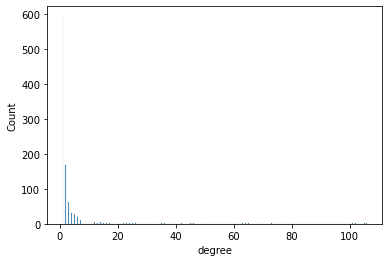

In [24]:
df_user_sample= df_user.sample(1000)
sn.histplot(data=df_user_sample, x='degree')

<AxesSubplot:xlabel='eigenvector', ylabel='Count'>

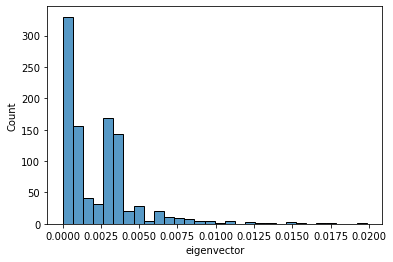

In [25]:
sn.histplot(data=df_user_sample, x='eigenvector')

<AxesSubplot:xlabel='pagerank', ylabel='Count'>

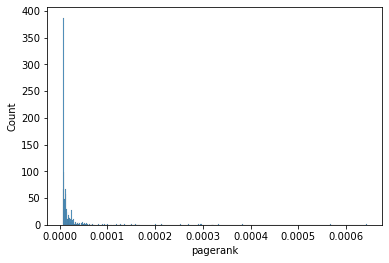

In [26]:
sn.histplot(data=df_user_sample, x='pagerank')

<AxesSubplot:xlabel='Cws', ylabel='Count'>

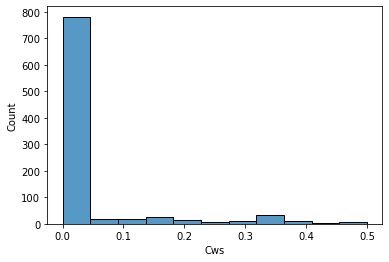

In [27]:
sn.histplot(data=df_user_sample, x='Cws',binrange=(0,0.5))

<AxesSubplot:xlabel='betweenness', ylabel='Count'>

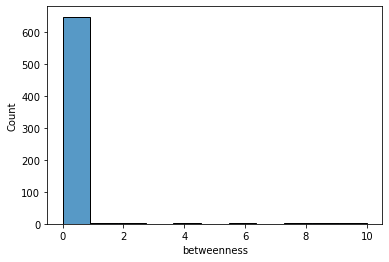

In [31]:
sn.histplot(data=df_user_sample, x='betweenness',binrange=(0,10))

#### Top 10 de influencers con mayor centralidad

In [33]:
data = {}
columns=['degree','betweenness','eigenvector','pagerank','Cws']
for col in columns:
    top_users = df_user.nlargest(10, columns=[col])['user'].tolist()
    data[col] = top_users
pd.DataFrame(data)

,degree,betweenness,eigenvector,pagerank,Cws
0,252168075,1314666648712998912,130979339,252168075,146621283
1,130979339,3330435293,73102744,130979339,712335069453688832
2,73102744,907618097791733761,252168075,73102744,813028689743114241
3,367933714,1006287782,367933714,593189095,1580608093
4,593189095,187588055,2687724840,367933714,166990862
5,2687724840,1342961725075816448,593189095,2687724840,405652622
6,931564592328781824,447986040,312708081,144929758,1633666736
7,144929758,1279408572,144929758,931564592328781824,1237140605395972097
8,312708081,1342106661926948864,931564592328781824,312708081,3381003869
9,1077176953,1001283130488172547,959033548379508736,1077176953,109295783


In [34]:
pd.DataFrame(np.concatenate(list(data.values()))).value_counts()

593189095              3
73102744               3
252168075              3
367933714              3
144929758              3
312708081              3
2687724840             3
130979339              3
931564592328781824     3
1077176953             2
712335069453688832     1
813028689743114241     1
907618097791733761     1
447986040              1
405652622              1
3381003869             1
3330435293             1
1001283130488172547    1
187588055              1
1006287782             1
166990862              1
1633666736             1
1580608093             1
146621283              1
1342961725075816448    1
1342106661926948864    1
1314666648712998912    1
1279408572             1
1237140605395972097    1
109295783              1
959033548379508736     1
dtype: int64

Observamos que existen unos cuantos usuarios que se repiten en el top 10 de cada uno de las métricas. Seleccionamos los usuarios 252168075, 130979339, 73102744 debido a que se encuentran más arriba en el top de las métricas. Procedemos entonces a analizar que tipo de tweets emitieron estos usuarios.

In [35]:
influencer = ['252168075','130979339', '73102744']
df_influencer = df[df['user.id'].isin(influencer)]

In [36]:
def remove_stopwords(s, language):
    s = ' '.join(w for w in tokenize.word_tokenize(s)
                 if not w in corpus.stopwords.words(language))
    return s

In [37]:
#Quitamos las stopwords y llevamos a minusculas las palabras de cada tweet
df_influencer = df_influencer.assign(
    clean_text = (
        df_influencer['full_text']
        .apply(lambda t: t.lower())
        .apply(lambda t: remove_stopwords(t, 'spanish'))
    )   
)

De los tweets emitidos por los usuarios seleccionados, nos quedamos con una muestra de las palabras más comunes, de forma tal de identificar lo que suelen postear en sus publicaciones.

In [38]:
def sample_text_from_col(df, n=1000,
                         text_col='clean_text'):
  """Extract a sample of text from column"""
  if n > len(df):
    n = len(df)
  return '\n'.join(df.sample(n)[text_col].values)

In [39]:
unique_users = df_influencer['user.id'].unique()
text_samples_for_user = {
    user: sample_text_from_col(df_influencer[df_influencer['user.id'] == user],text_col='clean_text')
    for user in unique_users
    if isinstance(user, str)
}
list(text_samples_for_user.keys())

['252168075', '73102744', '130979339']

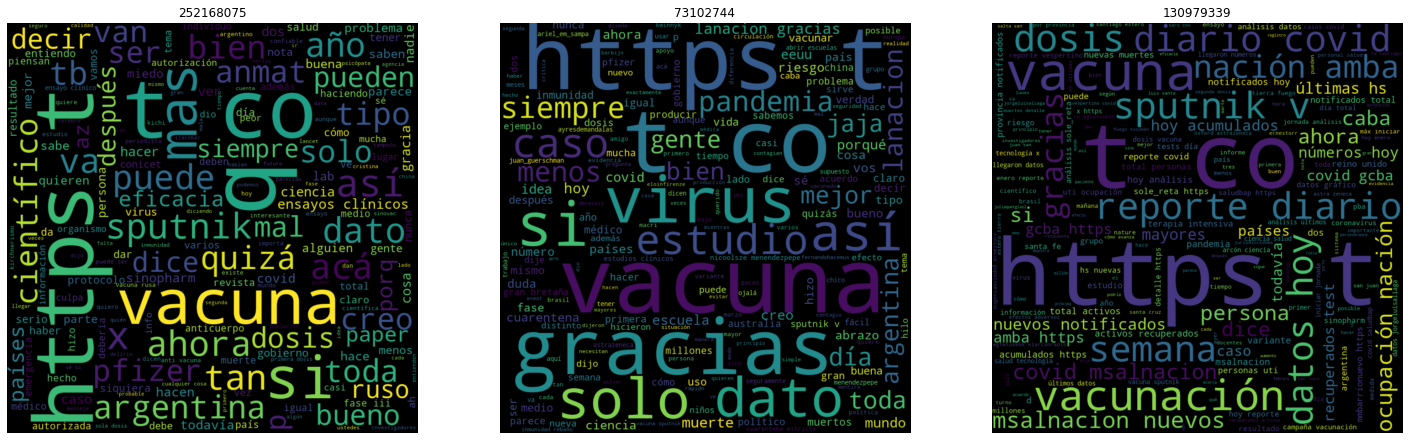

In [40]:
# Create general layout
n_cols = 3
n_rows = math.ceil(len(text_samples_for_user) / n_cols)

fig, axs = plt.subplots(n_rows, n_cols, figsize=(25, 40))
for i, (user, text_sample) in enumerate(text_samples_for_user.items()):
  wc = WordCloud(width=900, height=900, max_font_size=200)\
      .generate(text_sample)
  #row = math.floor(i / n_cols)
  col = i % n_cols
  ax = axs[col]
  ax.imshow(wc, interpolation='bilinear')
  ax.axis("off")
  ax.set_title(user)

Observando los gráficos anteriores, no podemos concluir si dichos usuarios están a favor o en contra de la vacunación, en principio el usuario 130979339 pareciera twittear con el objetivo de informar diferentes reportes diarios. Por otro lado, buscamos los perfiles de estos usuarios y corresponden con los siguientes:
- Usuario 252168075: https://twitter.com/norabar 
- Usuario 73102744: https://twitter.com/ernestorr 
- Usuario 130979339: https://twitter.com/spitta1969 

Los tres usuarios tienen una gran cantidad de seguidores y twittean con gran frecuencia en la red social. 

#### Opcional

Determinar si existe alguna correlación entre la centralidad de un nodo y su actividad en red social. Es decir, evaluar si los usuarios que más escriben son los más centrales o no.

In [41]:
df['user.id'].value_counts()

73102744               2195
252168075              1953
130979339              1061
2687724840              893
367933714               782
                       ... 
143601360                 1
842944941621960704        1
205437186                 1
1280677530949779457       1
413602077                 1
Name: user.id, Length: 42237, dtype: int64

Observamos que los usuarios que mayor actividad tienen en la red social, también son los centrales en nuestro grafo. 

### 3. Comunidades

Utilizar el algoritmo de Louvain con el parámetro "resolución" igual a 1. Caracterizar las comunidades halladas (cantidad, distribución de tamaños). Utilizar la modularidad y otras dos métricas a elección para evaluar la calidad de la partición encontrada. 

Variar el parámetro "resolución" y observar cómo cambia la distribución de comunidades encontradas. ¿Existe algún valor para el cual se identifiquen dos grandes comunidades?

#### 3.1 Algoritmo de Louvain

In [42]:
comms = algorithms.louvain(larg_G, resolution=1, randomize=False)

In [43]:
comm_df = pd.DataFrame({
    "communities": comms.communities,
    "comm_id": np.arange(0, len(comms.communities))
})

In [44]:
comm_df = comm_df.assign(comm_size=comm_df["communities"].apply(lambda c: len(c)))

In [45]:
densest_communities_df = comm_df.sort_values(by="comm_size", ascending=False).head(25)

In [46]:
densest_communities_df = (densest_communities_df.assign(
    percent_size=densest_communities_df["comm_size"].apply(
        lambda size: size / larg_G.number_of_nodes())))

Obtuvimos el porcentaje de usuarios que pertenecen a las 25 primeras comunidades.

In [47]:
densest_communities_df["percent_size"].sum()

0.9792462311557789

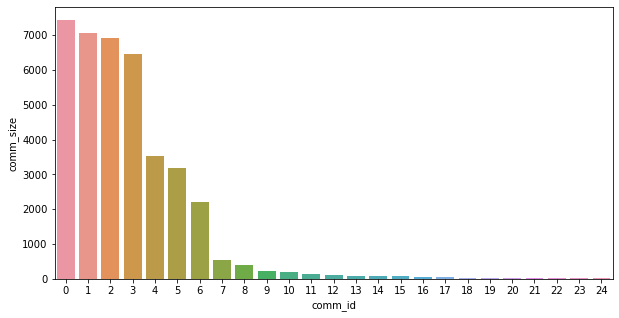

In [48]:
fig, ax = plt.subplots(figsize=(10, 5))
sn.barplot(data=densest_communities_df,
           x="comm_id",
           y="comm_size")
plt.show()

<AxesSubplot:xlabel='comm_size', ylabel='Count'>

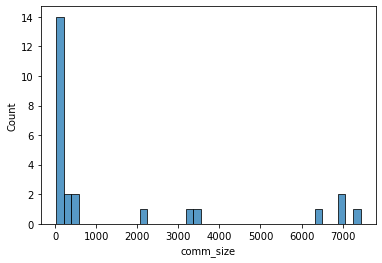

In [49]:
sn.histplot(data=densest_communities_df,
            x="comm_size",
            bins=40)

El algoritmo de Louvain con resolución igual a 1 encontró 360 comunidades de las
cuales el 7% de las comunidades (25 / 360), agrupa al 97% de los usuarios.

A continuación, calculamos la densidad y modularidad de dichas comunidades. 

In [50]:
m = larg_G.number_of_edges()
N = larg_G.number_of_nodes()
print('Densidad del grafo:', m/(N*(N-1)/2))
print('Internal edge density:', evaluation.internal_edge_density(larg_G, comms))

Densidad del grafo: 0.00011793432854364539
Internal edge density: FitnessResult(min=0, max=2.0, score=0.7079434162588341, std=0.46238287954461826)


In [51]:
print('Modularity:', evaluation.newman_girvan_modularity(larg_G, comms))

Modularity: FitnessResult(min=None, max=None, score=0.5651405380312197, std=None)


In [52]:
print('Modularity Density:', evaluation.modularity_density(larg_G, comms))

Modularity Density: FitnessResult(min=None, max=None, score=462.95372473516807, std=None)


In [53]:
print('Cut Ratio:', evaluation.cut_ratio(larg_G, comms))

Cut Ratio: FitnessResult(min=0.0, max=4.712410333480509e-05, score=2.018625986520876e-06, std=7.059900914136106e-06)


In [54]:
resolutions = range(1,10,1)
data = []
for resolution in resolutions:
   
    comms_lv = algorithms.louvain(larg_G, resolution=resolution, randomize=False)
    ncomms = len(comms_lv.communities)
    comms_size = [len(c) for c in comms_lv.communities]
    comms_size.sort()
    modularity = evaluation.newman_girvan_modularity(larg_G, comms_lv).score
    density = evaluation.internal_edge_density(larg_G, comms_lv).score
    data.append((resolution, ncomms, modularity,density, comms_size[-1],  comms_size[-2]))
    
comm_lv_df = pd.DataFrame(data, columns=['resolutions', 'ncomms', 'modularity','density','greatestcomms1', 'greatestcomms2'])
comm_lv_df

,resolutions,ncomms,modularity,density,greatestcomms1,greatestcomms2
0,1,356,0.565141,0.707943,7438,7063
1,2,356,0.529254,0.728656,19269,15479
2,3,348,0.504711,0.724707,22435,15684
3,4,336,0.503219,0.737114,22570,15727
4,5,330,0.502143,0.744595,22649,15768
5,6,326,0.501454,0.750501,22718,15768
6,7,323,0.500824,0.755768,22784,15768
7,8,321,0.500188,0.760027,22850,15768
8,9,321,0.500109,0.760029,22857,15768


In [55]:
comm_lv_df['n_nodes'] = len(larg_G.nodes())

In [56]:
comm_lv_df

,resolutions,ncomms,modularity,density,greatestcomms1,greatestcomms2,n_nodes
0,1,356,0.565141,0.707943,7438,7063,39800
1,2,356,0.529254,0.728656,19269,15479,39800
2,3,348,0.504711,0.724707,22435,15684,39800
3,4,336,0.503219,0.737114,22570,15727,39800
4,5,330,0.502143,0.744595,22649,15768,39800
5,6,326,0.501454,0.750501,22718,15768,39800
6,7,323,0.500824,0.755768,22784,15768,39800
7,8,321,0.500188,0.760027,22850,15768,39800
8,9,321,0.500109,0.760029,22857,15768,39800


Observamos que a partir de la resolución 2, el algoritmo de Louvain encuentra dos grandes comunidades, siendo el resto minoría. 

A su vez, observamos que a medida que aumenta la resolución la modularidad disminuye pero la densidad aumenta, teniendo poca variabilidad. 

#### 3.2 Algoritmo de Leiden (mejora de Louvain)

Elegir otro algoritmo de detección de comunidades y comparar los resultados con los obtenidos anteriormente.

In [57]:
comms_leid = algorithms.leiden(larg_G)

In [58]:
comm_df = pd.DataFrame({
    "communities": comms_leid.communities,
    "comm_id": np.arange(0, len(comms_leid.communities))
})

In [59]:
comm_df = comm_df.assign(comm_size=comm_df["communities"].apply(lambda c: len(c)))

In [60]:
comm_df.head(10)

,communities,comm_id,comm_size
0,"[1314666648712998912, 1026561440, 4516988123, ...",0,7634
1,"[2412575347, 862058688118480897, 7685439994645...",1,6774
2,"[146621283, 1300538383136100353, 3701352916, 4...",2,6451
3,"[351115972, 106473747, 1333021921877909508, 28...",3,6280
4,"[1171384413948710916, 1568951060, 127677532241...",4,3473
5,"[480627466, 810065724, 387199960, 565549622, 1...",5,3414
6,"[1179789999266504704, 813028689743114241, 1254...",6,2340
7,"[2252264887, 3001905353, 964237368, 3054107071...",7,759
8,"[1266212657272696832, 155911328, 301965864, 21...",8,504
9,"[121474081, 1282168010070007809, 9362930922689...",9,212


In [61]:
m = larg_G.number_of_edges()
N = larg_G.number_of_nodes()
print('Densidad del grafo:', m/(N*(N-1)/2))
print('Internal edge density:', evaluation.internal_edge_density(larg_G, comms_leid))

Densidad del grafo: 0.00011793432854364539
Internal edge density: FitnessResult(min=0, max=3.0, score=0.6964820477137592, std=0.4639367294780134)


In [62]:
print('Modularity:', evaluation.newman_girvan_modularity(larg_G, comms_leid))

Modularity: FitnessResult(min=None, max=None, score=0.5865466877547763, std=None)


In [63]:
print('Modularity Density:', evaluation.modularity_density(larg_G, comms_leid))

Modularity Density: FitnessResult(min=None, max=None, score=496.8412935569655, std=None)


In [64]:
print('Cut Ratio:', evaluation.cut_ratio(larg_G, comms_leid))

Cut Ratio: FitnessResult(min=0.0, max=4.2160678739465385e-05, score=3.220363769830048e-06, std=8.291653376792695e-06)


Implementamos el algoritmo de Leiden, el cual es una versión mejorada del algoritmo de Louvain. Observando las métricas de modularidad y densidad, se concluye que los resultados alcanzados son muy parecidos para ambos algoritmos.

#### Opcional

Correr el algoritmo de Louvain con distintas semillas aleatorias. Utilizar alguna métrica de comparación externa entre las particiones obtenidas para determinar en qué medida depende el algoritmo de la condición inicial.

In [65]:
randomize = range(1,10,1)
data = []
for seed in randomize:
   
    comms_lv = algorithms.louvain(larg_G, resolution= 2 , randomize=seed)
    ncomms = len(comms_lv.communities)
    comms_size = [len(c) for c in comms_lv.communities]
    comms_size.sort()
    modularity = evaluation.newman_girvan_modularity(larg_G, comms_lv).score
    density = evaluation.internal_edge_density(larg_G, comms_lv).score
    data.append((seed, ncomms, modularity, density, comms_size[-1],  comms_size[-2]))
    
comm_lvs_df = pd.DataFrame(data, columns=['seeds', 'ncomms', 'modularity', 'density','greatestcomms1', 'greatestcomms2'])
comm_lvs_df

,seeds,ncomms,modularity,density,greatestcomms1,greatestcomms2
0,1,370,0.528839,0.709748,19353,15477
1,2,386,0.530472,0.708044,19427,15249
2,3,362,0.528721,0.720557,19380,15471
3,4,357,0.528683,0.720950,19371,15486
4,5,368,0.528729,0.721140,19380,15469
5,6,353,0.528987,0.719724,19322,15477
6,7,356,0.529101,0.723816,19300,15473
7,8,365,0.530205,0.709215,19458,15268
8,9,356,0.528633,0.722218,19372,15471


Observamos que al variar la semilla aleatoria, no cambian considerablemente las métricas, ni tampoco el tamaño de las dos comunidades más grandes. 